In [1]:
import sys
import json
import numpy as np
from tqdm.notebook import tqdm
from toolz.curried import pipe, curry, compose


import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader


import chnet.ch_tools as ch_tools
import chnet.utilities as ch_utils
import chnet.ch_generator as ch_gen
from chnet.ch_loader import CahnHillDataset


def localization_train(
              n_state=5,
              domain = (-1.1, 1.1),
              mid=0.0, 
              dif=0.449, 
              dim_x=96, 
              dx=0.25, 
              dt=0.01, 
              gamma=0.2, 
              nstep=2,
              init_steps=1, 
              n_samples=1024, 
              final_tstep=501, 
              seed=68457542, 
              device="cuda"):
    
    from pymks.bases import LegendreBasis
    from pymks import MKSLocalizationModel
    print("Start MKS Training")
    device = torch.device("cuda:0") if device == "cuda" else torch.device("cpu")
    torch.cuda.empty_cache()
    x_inp, y_inp = ch_gen.data_generator(nsamples=n_samples, 
                                  dim_x=dim_x, 
                                  init_steps=init_steps, 
                                  delta_sim_steps = (final_tstep-init_steps)//nstep,
                                  dx=dx, 
                                  dt=dt,
                                  m_l=mid-dif, 
                                  m_r=mid+dif,
                                  n_step=nstep,
                                  gamma=gamma, 
                                  seed=seed,
                                  device=device)
    x_inp, y_inp = x_inp[:,0], y_inp[:,-1]
    basis = LegendreBasis(n_state, domain)
    model = MKSLocalizationModel(basis)
    model.fit(x_inp, y_inp)
    print("End MKS Training")
    return model


def localization_validate(model, 
                          mid=0.0, 
                          dif=0.449, 
                          dim_x=96, 
                          dx=0.25, 
                          dt=0.01, 
                          gamma=0.2, 
                          nstep=2,
                          init_steps=1, 
                          n_samples=32, 
                          final_tstep=501, 
                          seed=8634132, 
                          device="cuda",
                          n_items=5,
                          vis=True):
    
    from chnet.ssim import SSIM
    ssim_loss = SSIM(window_size=11)
    
    mae_loss_npy = lambda x1, x2: np.mean(np.fabs(x1.numpy()-x2.numpy()))

    print("Start Validation")
    torch.cuda.empty_cache()
    x_val, y_val = ch_gen.data_generator(nsamples=n_samples, 
                                  dim_x=dim_x, 
                                  init_steps=init_steps, 
                                  delta_sim_steps = (final_tstep-init_steps)//nstep,
                                  dx=dx, 
                                  dt=dt,
                                  m_l=mid-dif, 
                                  m_r=mid+dif,
                                  n_step=nstep,
                                  gamma=gamma, 
                                  seed=seed,
                                  device=device)
    
    x_val, y_val = x_val[:,0], y_val[:,-1]
    y_prd = model.predict(x_val)
    
    errs = []
    for ix in tqdm(range(n_samples)):

        im_x  = torch.tensor(x_val[ix])
        im_y1 = torch.tensor(y_val[ix])
        im_y2 = torch.tensor(y_prd[ix])
        errs.append(mae_loss_npy(im_y1, im_y2))

        if vis:
            if ((ix+1) % (n_samples//n_items)) == 0:
                ch_utils.draw_by_side([im_x, im_y1, im_y2], 
                                      sub_titles=["inp", "sim", "cnn"], 
                                      scale=8, vmin=None, vmax=None)
                

                print("mae: {}, inp: {:1.3f}, sim: {:1.3f}, cnn: {:1.3f}".format(errs[-1], 
                                ssim_loss(im_y1[None, None], im_x[None, None]).item(),
                                ssim_loss(im_y1[None, None], im_y1[None, None]).item(), 
                                ssim_loss(im_y1[None, None], im_y2[None, None]).item()))
    return errs

0


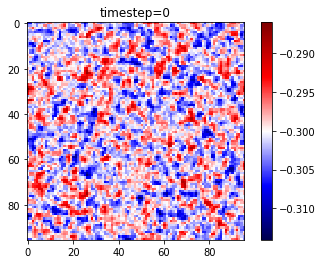

400


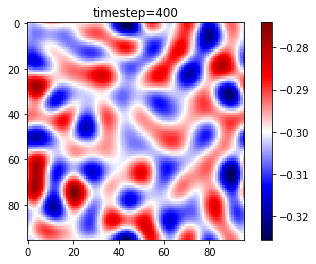

800


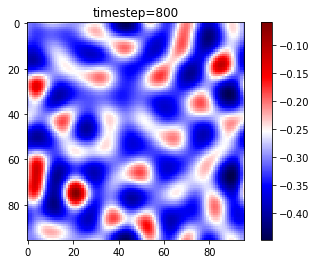

1200


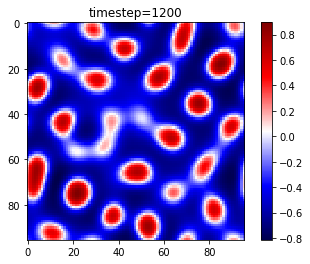

1600


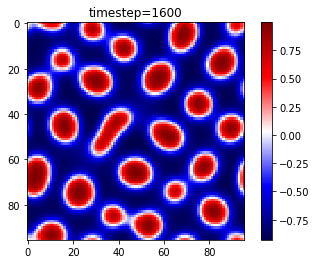

2000


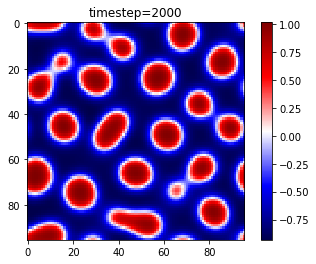

0


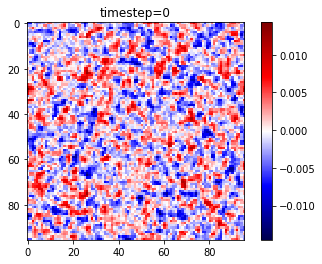

400


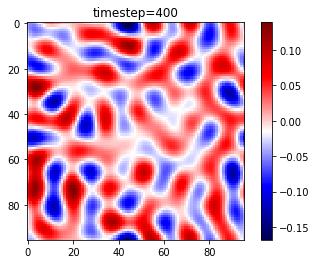

800


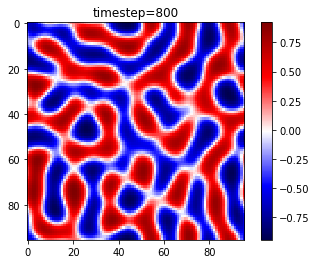

1200


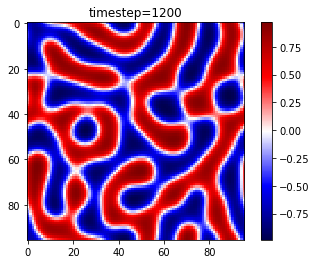

1600


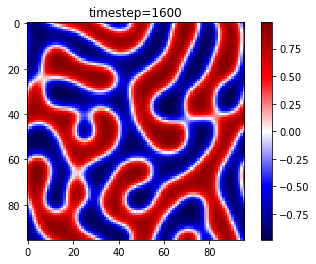

2000


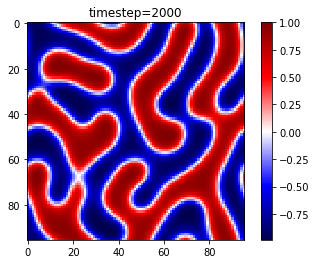

0


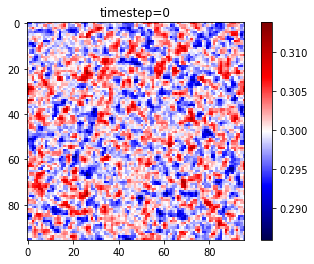

400


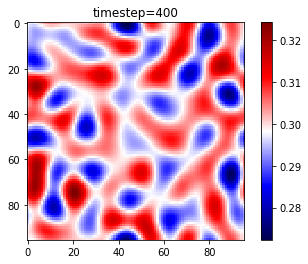

800


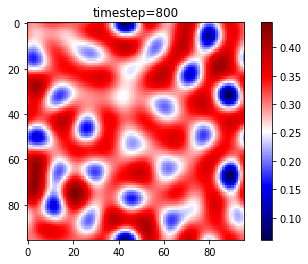

1200


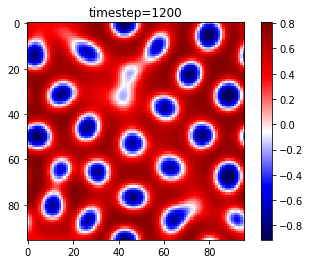

1600


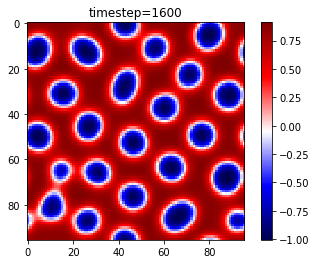

2000


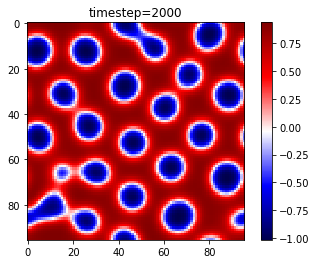

In [6]:
n_state=5
domain = (-1.1, 1.1)
mid=0.0
dif=1e-4
dim_x=96
dx=0.25
dt=0.01
gamma=0.2
nstep=6
init_steps=1
n_samples=2
final_tstep=2001
seed=68457542
device="cuda"
device = torch.device("cuda:0") if device == "cuda" else torch.device("cpu")
torch.cuda.empty_cache()
micros = {}
for mid in [-.3, 0.0, .3]:
    
    x_inp, y_inp = ch_gen.data_generator(nsamples=n_samples, 
                                  dim_x=dim_x, 
                                  init_steps=init_steps, 
                                  delta_sim_steps = (final_tstep-init_steps)//nstep,
                                  dx=dx, 
                                  dt=dt,
                                  m_l=mid-dif, 
                                  m_r=mid+dif,
                                  n_step=nstep,
                                  gamma=gamma, 
                                  seed=seed,
                                  device=device)
    micros[mid] = x_inp[0]
    for i in range(nstep):
        print(i*400)
        ch_utils.draw_im(x_inp[0,i], vmax=None, vmin=None, title="timestep={}".format(i*400))

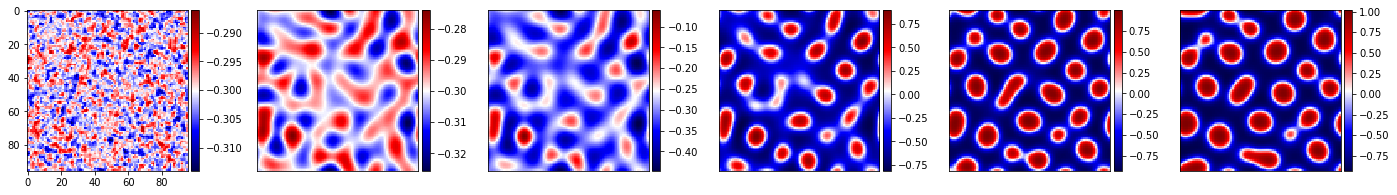

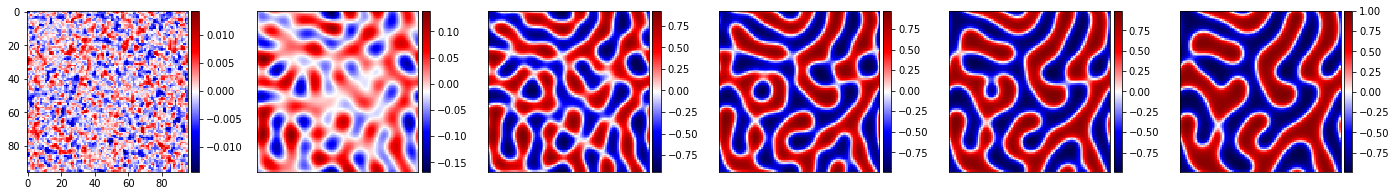

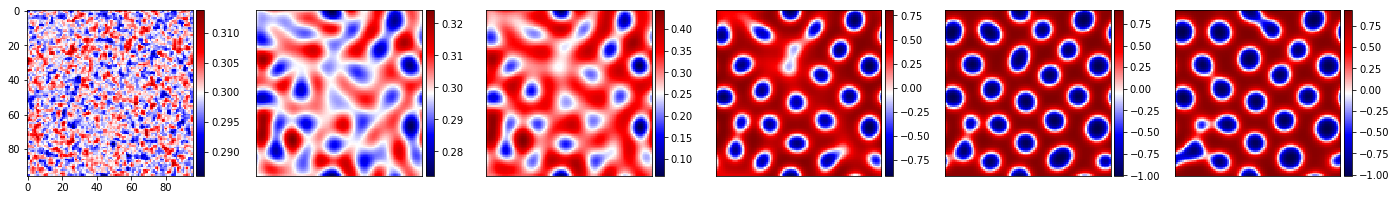

In [16]:
for m in [-0.3, 0.0, 0.3]:
    ch_utils.draw_by_side([micros[m][ix,...] for ix in range(nstep)], vmax=None, vmin=None, scale=12)

MKS 1-101
Start MKS Training


/storage/home/hhive1/ashanker9/data/anaconda3/envs/chnet/lib/python3.7/site-packages/ipykernel_launcher.py:55: DeprecationWarning: Call to deprecated method wrapper. (Use pymks.fmks instead.) -- Deprecated since version 0.4.
/storage/home/hhive1/ashanker9/data/anaconda3/envs/chnet/lib/python3.7/site-packages/ipykernel_launcher.py:56: DeprecationWarning: Call to deprecated method wrapper. (Use pymks.fmks instead.) -- Deprecated since version 0.4.


End MKS Training
Start Validation


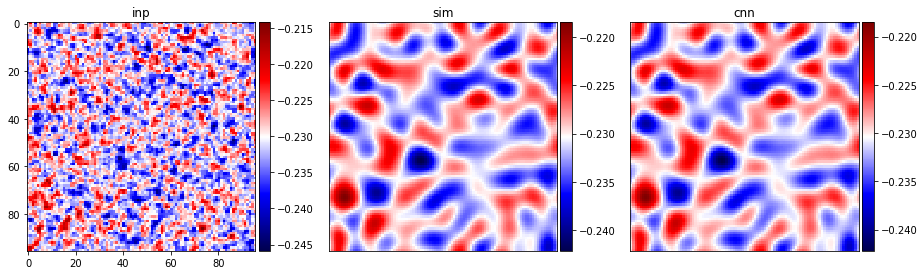

mae: 1.4306926475404394e-05, inp: 0.986, sim: 1.000, cnn: 1.000


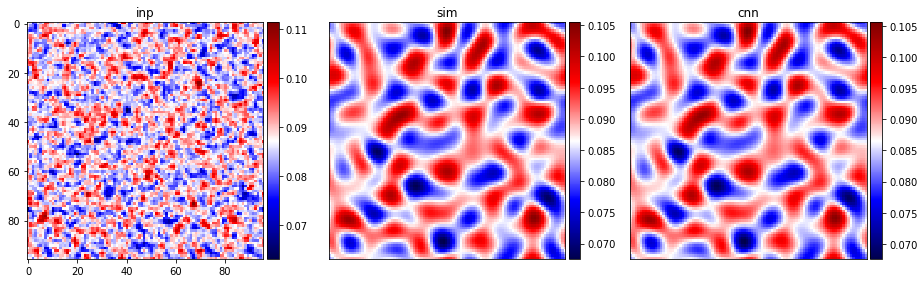

mae: 1.8813732156028558e-05, inp: 0.970, sim: 1.000, cnn: 1.000

MKS 1-401
Start MKS Training
End MKS Training
Start Validation


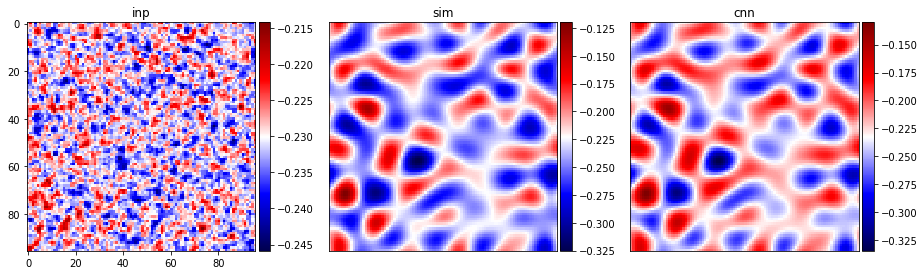

mae: 0.0010009140889834795, inp: 0.858, sim: 1.000, cnn: 1.000


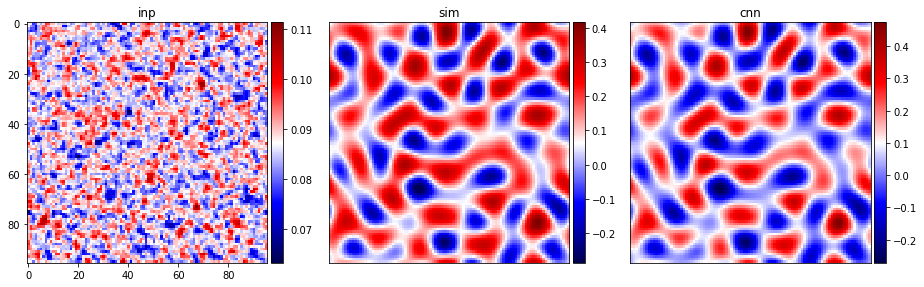

mae: 0.006444130617918309, inp: 0.157, sim: 1.000, cnn: 0.989

MKS 1-801
Start MKS Training
End MKS Training
Start Validation


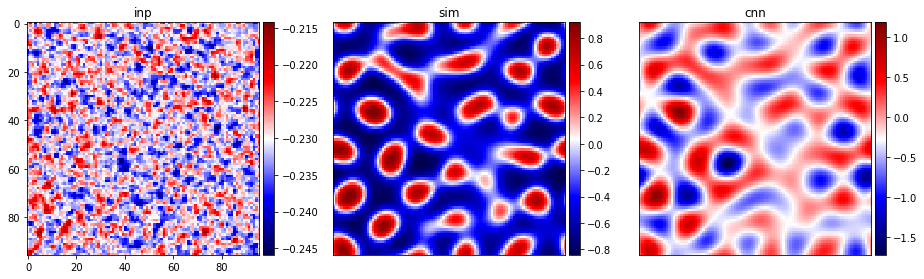

mae: 0.1386698220531178, inp: 0.066, sim: 1.000, cnn: 0.682


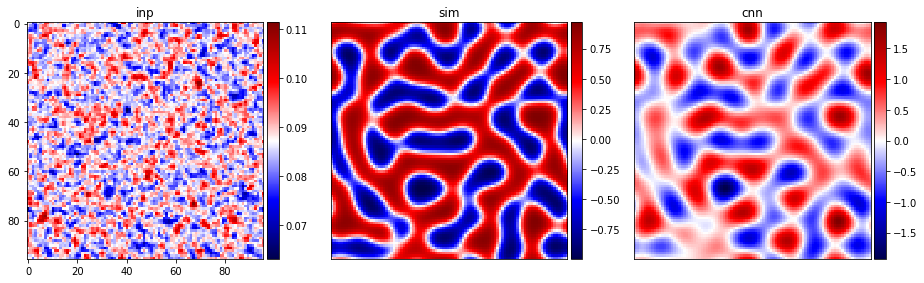

mae: 0.1720751232440349, inp: 0.008, sim: 1.000, cnn: 0.687

MKS 401-801
Start MKS Training
End MKS Training
Start Validation


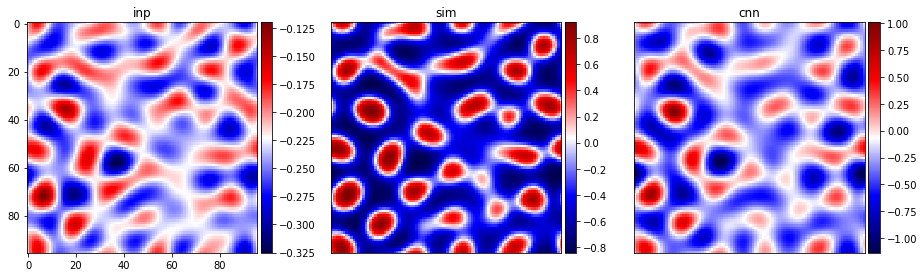

mae: 0.15621006516529634, inp: 0.117, sim: 1.000, cnn: 0.608


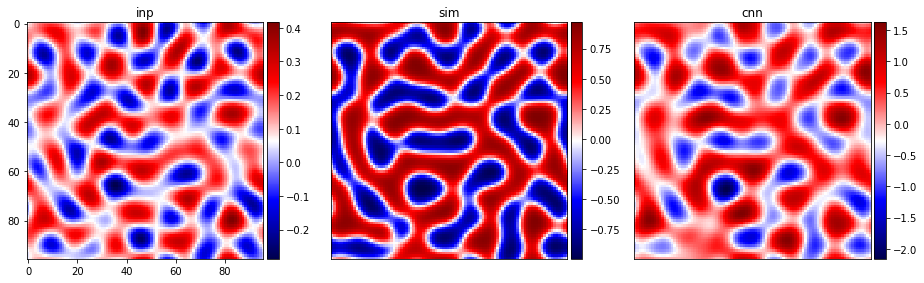

mae: 0.19117958244658442, inp: 0.140, sim: 1.000, cnn: 0.673

MKS 801-1201
Start MKS Training
End MKS Training
Start Validation


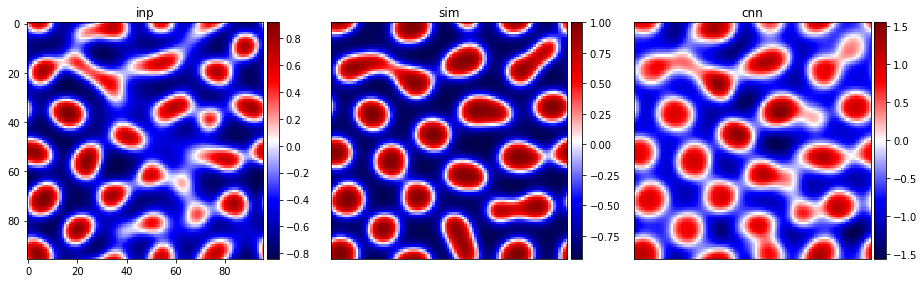

mae: 0.13984870714987577, inp: 0.545, sim: 1.000, cnn: 0.781


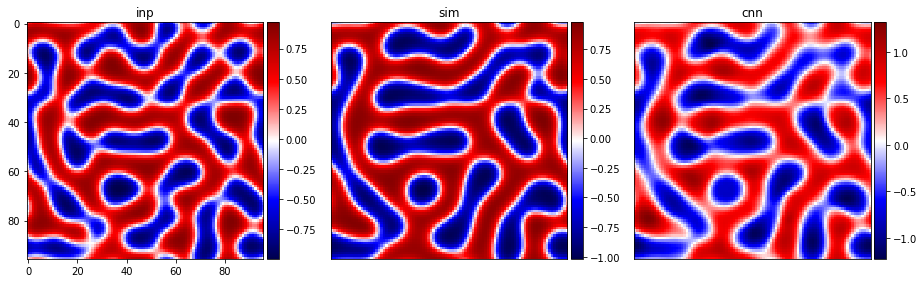

mae: 0.10761908598385299, inp: 0.515, sim: 1.000, cnn: 0.835

MKS 1201-1601
Start MKS Training
End MKS Training
Start Validation


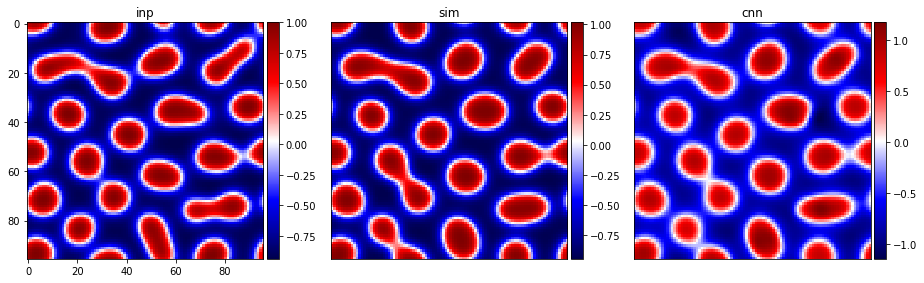

mae: 0.060998396245645084, inp: 0.742, sim: 1.000, cnn: 0.914


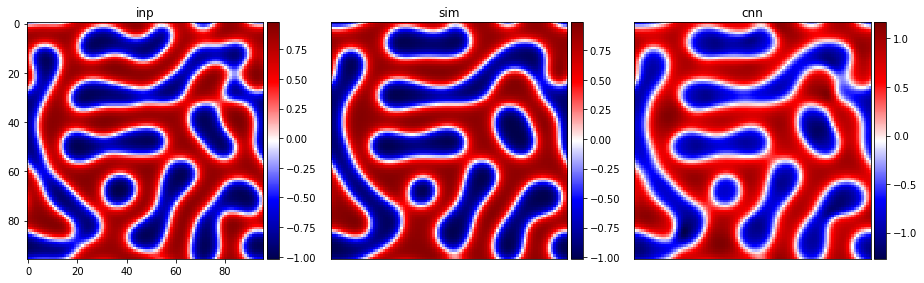

mae: 0.06655275685985668, inp: 0.664, sim: 1.000, cnn: 0.904

MKS 1601-2001
Start MKS Training
End MKS Training
Start Validation


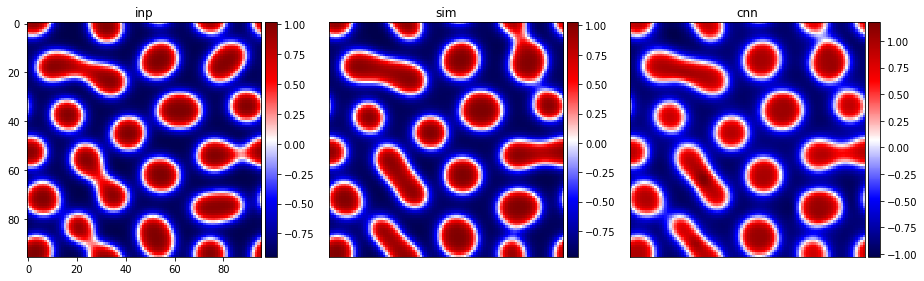

mae: 0.045206445847754496, inp: 0.782, sim: 1.000, cnn: 0.937


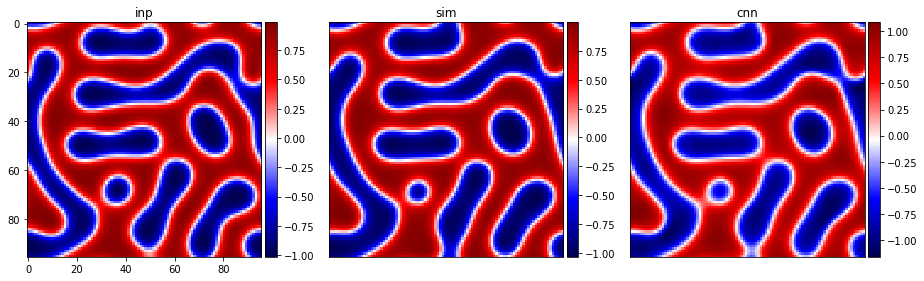

mae: 0.04532812858172278, inp: 0.719, sim: 1.000, cnn: 0.939

MKS 2001-2401
Start MKS Training
End MKS Training
Start Validation


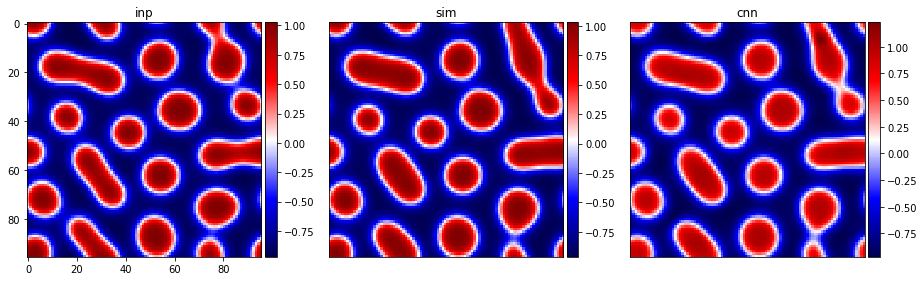

mae: 0.03489121035608371, inp: 0.785, sim: 1.000, cnn: 0.953


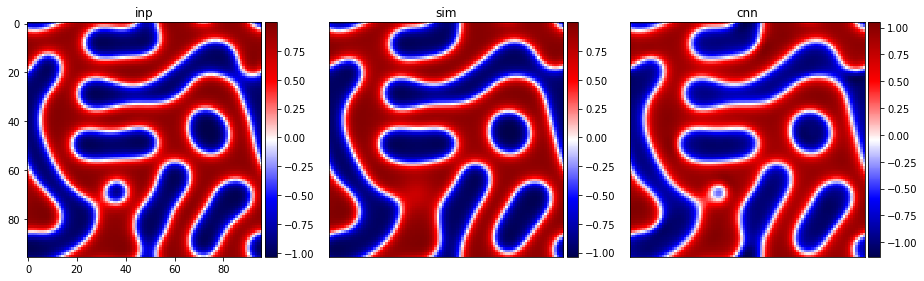

mae: 0.04144498778896345, inp: 0.747, sim: 1.000, cnn: 0.937




In [4]:
errs_dct = {}
init_steps = [1, 1, 1, 401, 801, 1201, 1601, 2001]
final_steps = [101, 401, 801, 801, 1201, 1601, 2001, 2401]
for init_step, final_tstep in tqdm(zip(init_steps, final_steps)):
    key = "MKS {}-{}".format(init_step, final_tstep)
    print(key)
    
    model0 = localization_train(n_state=11,
                              dif=0.35, 
                              init_steps=init_step, 
                              final_tstep=final_tstep,
                              n_samples=2048,)

    errs_dct[key] = localization_validate(model0,
                                      dif=0.35, 
                                      init_steps=init_step, 
                                      final_tstep=final_tstep,
                                      n_samples=1024,
                                      n_items=2)

In [7]:
import pandas as pd
df_errs = pd.DataFrame(errs_dct)
df_errs.to_csv("errs_allMksModels.csv")

In [8]:
df_errs.describe()

,MKS 1-101,MKS 1-401,MKS 1-801,MKS 401-801,MKS 801-1201,MKS 1201-1601,MKS 1601-2001,MKS 2001-2401
count,1.024000e+03,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000
mean,2.028425e-05,0.002584,0.139755,0.152781,0.122808,0.073678,0.050771,0.040824
std,1.216805e-05,0.001659,0.061161,0.052387,0.023131,0.012861,0.006961,0.006726
min,7.523791e-07,0.000132,0.005498,0.042457,0.072233,0.049648,0.032146,0.025966
25%,1.179310e-05,0.001036,0.100909,0.118110,0.107600,0.065802,0.045956,0.036252
50%,1.602281e-05,0.002651,0.169137,0.174664,0.114801,0.071249,0.050216,0.040343
75%,3.267440e-05,0.003813,0.182345,0.189172,0.129621,0.077240,0.054915,0.044896
max,4.680852e-05,0.006818,0.222309,0.251278,0.197577,0.153024,0.078595,0.071330
